In [ ]:
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

In [ ]:
channels = 1 # suggested default : 1, number of image channels (gray scale)
img_size = 28 # suggested default : 28, size of each image dimension
img_shape = (channels, img_size, img_size) # (Channels, Image Size(H), Image Size(W))

In [ ]:
latent_dim = 100 # suggested default. dimensionality of the latent space
batch_size = 64  # suggested default, size of the batches

In [ ]:
cuda = True if torch.cuda.is_available() else False # GPU Setting

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(input_features, output_features, normalize=True):
            layers = [nn.Linear(input_features, output_features)]
            if normalize: # Default
                layers.append(nn.BatchNorm1d(output_features, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True)) # inplace=True : modify the input directly. It can slightly decrease the memory usage.
            return layers # return list of layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False), # Asterisk('*') in front of block means unpacking list of layers - leave only values(layers) in list
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))), # np.prod(1, 28, 28) == 1*28*28
            nn.Tanh() # result : from -1 to 1
        )

    def forward(self, z): # z == latent vector(random input vector)
        img = self.model(z) # (64, 100) --(model)--> (64, 784)
        img = img.view(img.size(0), *img_shape) # img.size(0) == N(Batch Size), (N, C, H, W) == default --> (64, 1, 28, 28)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512), # (28*28, 512)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid() # result : from 0 to 1
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1) #flatten -> from (64, 1, 28, 28) to (64, 1*28*28)
        validity = self.model(img_flat) # Discriminate -> Real? or Fake? (64, 784) -> (64, 1)
        return validity

In [ ]:
adversarial_loss = torch.nn.BCELoss()

In [ ]:
generator = Generator()
discriminator = Discriminator()

In [ ]:
generator

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=784, bias=True)
    (12): Tanh()
  )
)

In [ ]:
discriminator

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [ ]:
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [ ]:
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

mnist_trainset = datasets.MNIST('mnist_data', train=True, download=True, transform=T)
mnist_testset = datasets.MNIST('mnist_data', train=False, download=True, transform=T)

mnist_train_dl = torch.utils.data.DataLoader(mnist_trainset, batch_size = batch_size)
mnist_test_dl = torch.utils.data.DataLoader(mnist_testset, batch_size = batch_size)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 37.9MB/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.04MB/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 9.23MB/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.52MB/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [ ]:
# suggested default - beta parameters (decay of first order momentum of gradients)
b1 = 0.5
b2 = 0.999

# suggested default - learning rate
lr = 0.0002

In [ ]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1,b2))

In [ ]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
# Visualize result
import matplotlib.pyplot as plt

  0%|          | 0/938 [00:00<?, ?it/s]

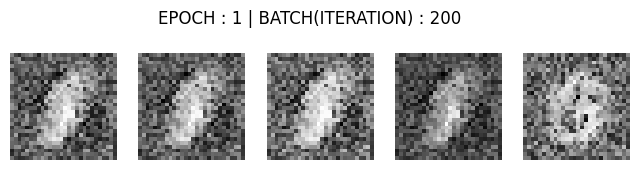

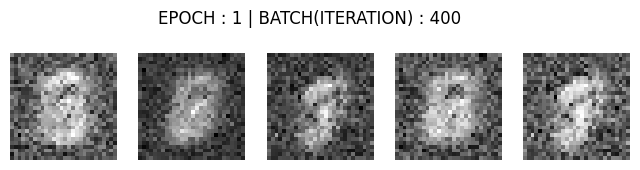

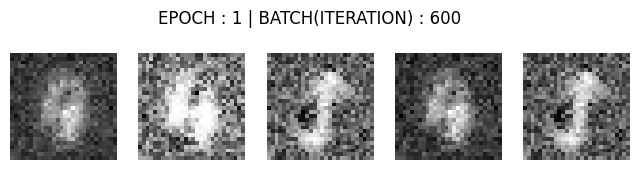

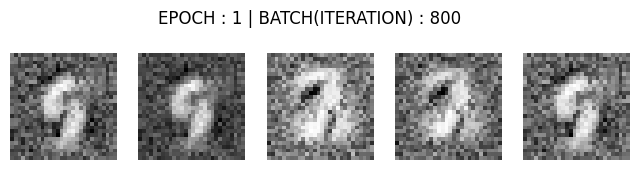

[Epoch: 1/10] [Batch: 938/938] [D loss: 0.492307] [G loss: 1.052199]


  0%|          | 0/938 [00:00<?, ?it/s]

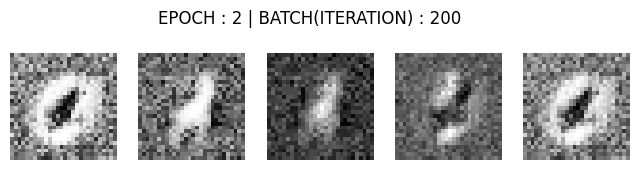

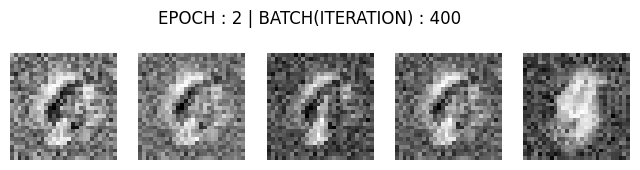

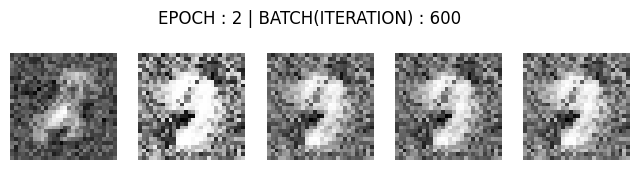

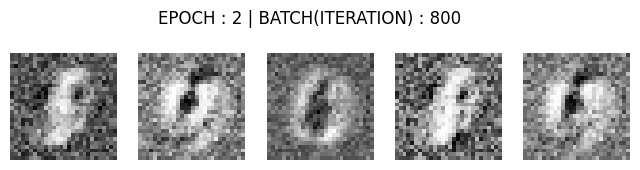

[Epoch: 2/10] [Batch: 938/938] [D loss: 0.396517] [G loss: 1.119145]


  0%|          | 0/938 [00:00<?, ?it/s]

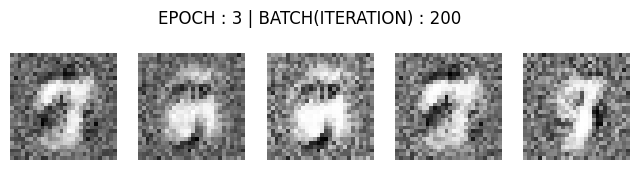

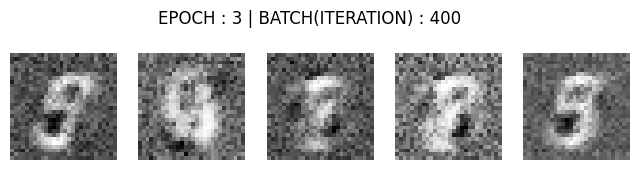

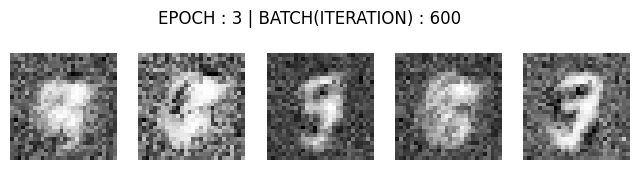

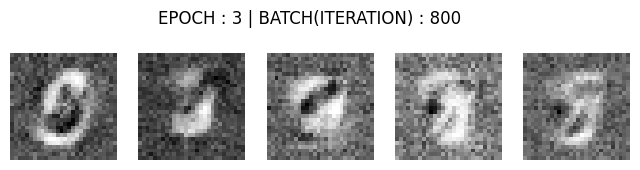

[Epoch: 3/10] [Batch: 938/938] [D loss: 0.355469] [G loss: 1.603811]


  0%|          | 0/938 [00:00<?, ?it/s]

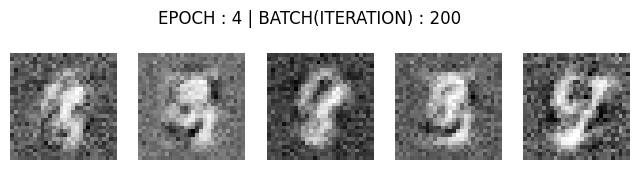

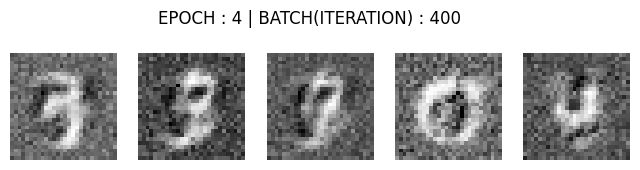

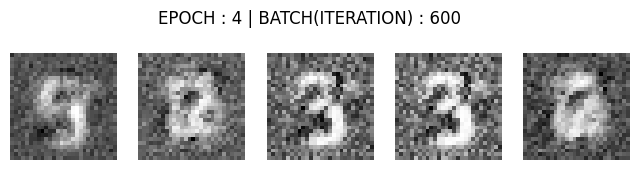

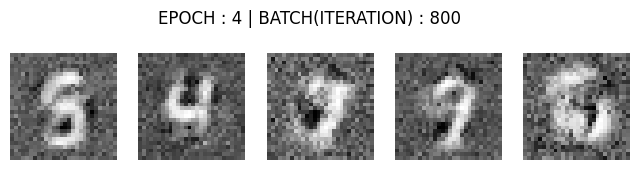

[Epoch: 4/10] [Batch: 938/938] [D loss: 0.279851] [G loss: 1.692585]


  0%|          | 0/938 [00:00<?, ?it/s]

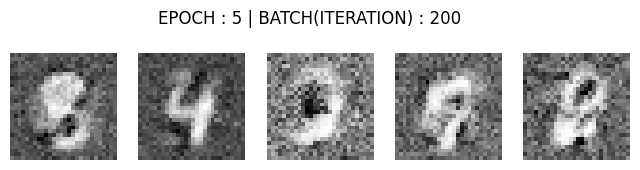

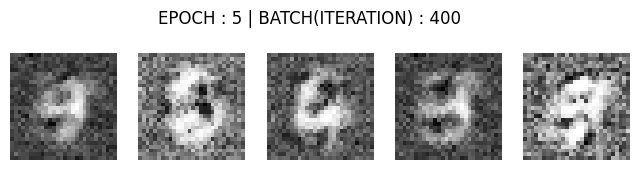

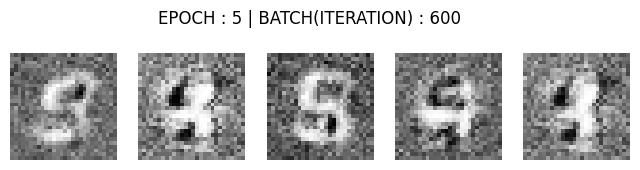

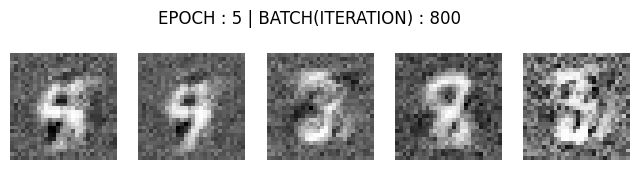

[Epoch: 5/10] [Batch: 938/938] [D loss: 0.214260] [G loss: 2.657935]


  0%|          | 0/938 [00:00<?, ?it/s]

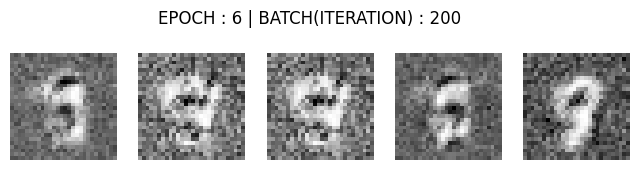

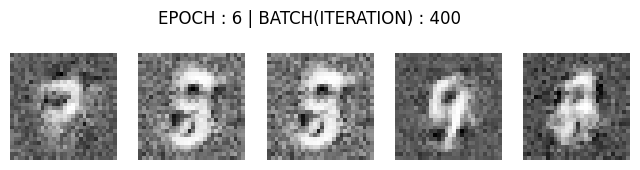

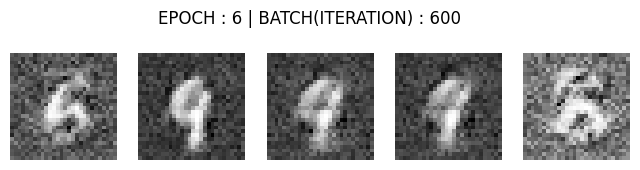

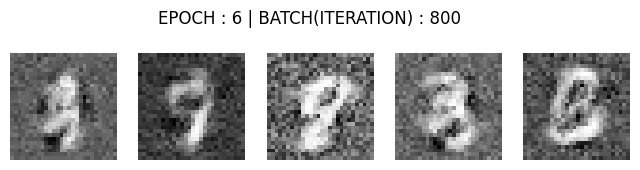

[Epoch: 6/10] [Batch: 938/938] [D loss: 0.326968] [G loss: 2.281447]


  0%|          | 0/938 [00:00<?, ?it/s]

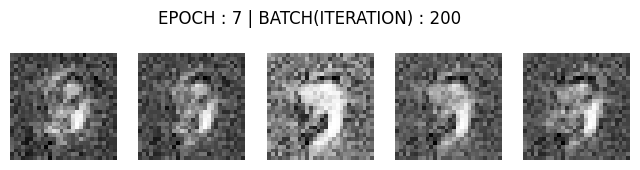

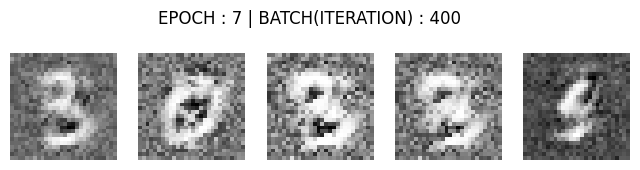

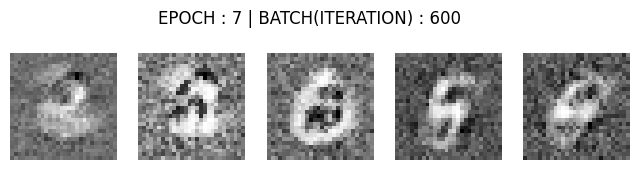

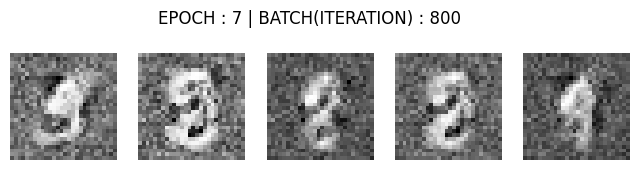

[Epoch: 7/10] [Batch: 938/938] [D loss: 0.188750] [G loss: 1.990577]


  0%|          | 0/938 [00:00<?, ?it/s]

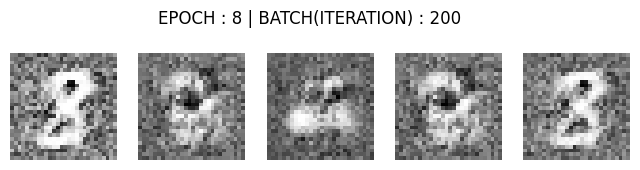

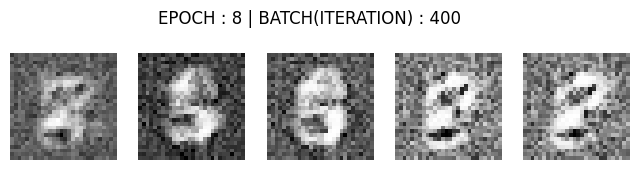

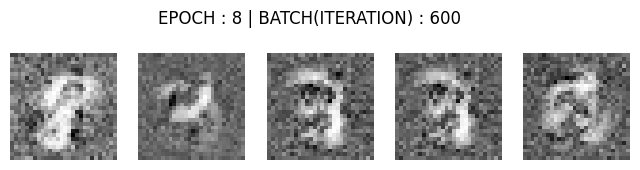

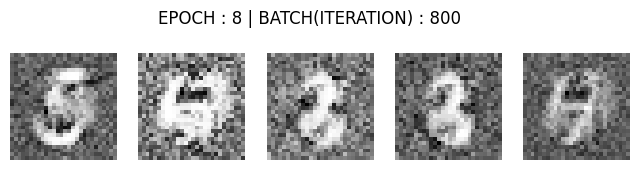

[Epoch: 8/10] [Batch: 938/938] [D loss: 0.265077] [G loss: 1.906283]


  0%|          | 0/938 [00:00<?, ?it/s]

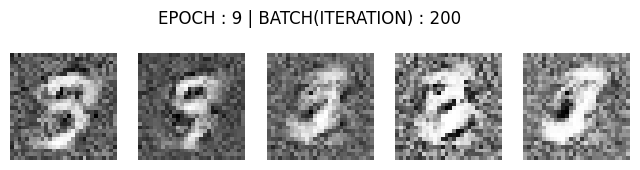

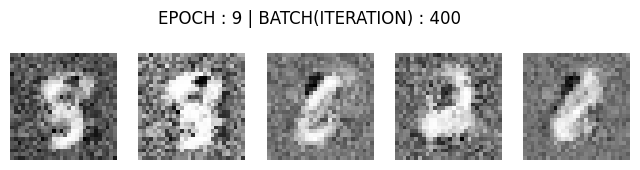

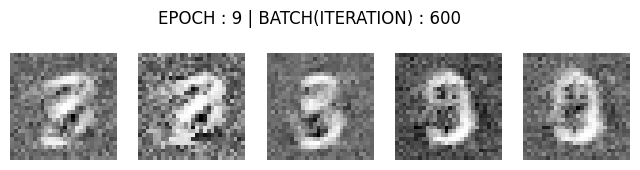

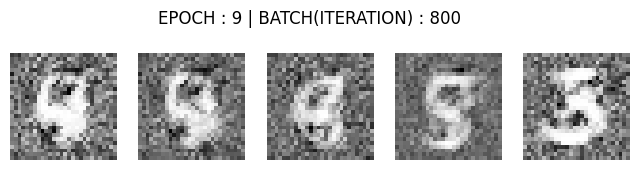

[Epoch: 9/10] [Batch: 938/938] [D loss: 0.147402] [G loss: 2.370968]


  0%|          | 0/938 [00:00<?, ?it/s]

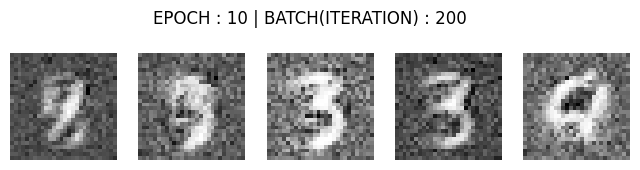

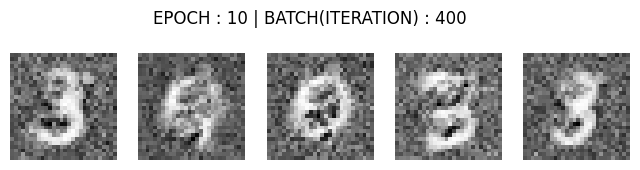

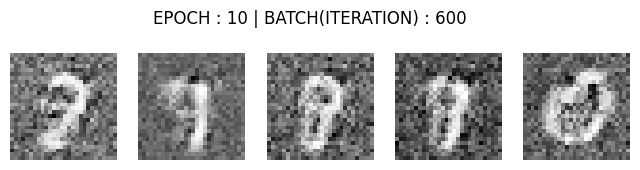

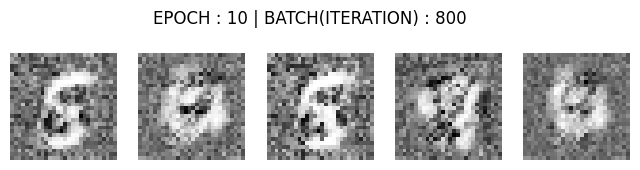

[Epoch: 10/10] [Batch: 938/938] [D loss: 0.374280] [G loss: 1.594520]


In [ ]:
n_epochs = 10 # suggested default = 200
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(tqdm(mnist_train_dl)): # This code(enumerate) is dealt with once more in the *TEST_CODE below.
                                                     # Used 'tqdm' for showing progress

        # Adversarial ground truths (For more detail, refer *Read_More below)
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False) # imgs.size(0) == batch_size(1 batch) == 64, *TEST_CODE
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False) # And Variable is for caclulate gradient. In fact, you can use it, but you don't have to.
                                                                                # requires_grad=False is default in tensor type. *Read_More

        # Configure input
        real_imgs = imgs.type(Tensor) # As mentioned, it is no longer necessary to wrap the tensor in a Variable.
      # real_imgs = Variable(imgs.type(Tensor)) # requires_grad=False, Default! It's same.

# ------------
# Train Generator
# ------------
        optimizer_G.zero_grad()

        # sample noise 'z' as generator input
        z = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim))) # Random sampling Tensor(batch_size, latent_dim) of Gaussian distribution
        # z.shape == torch.Size([64, 100])

        # Generate a batch of images
        gen_imgs = generator(z)
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)

        g_loss.backward()
        optimizer_G.step()

# ------------
# Train Discriminator
# ------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid) # torch.nn.BCELoss() compare result(64x1) and valid(64x1, filled with 1)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake) # We are learning the discriminator now. So have to use detach()

        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()# If didn't use detach() for gen_imgs, all weights of the generator will be calculated with backward().
        optimizer_D.step()



# ------------
# Real Time Visualization (While Training)
# ------------

        sample_z_in_train = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim)))
        # z.shape == torch.Size([64, 100])
        sample_gen_imgs_in_train = generator(sample_z_in_train).detach().cpu()
        # gen_imgs.shape == torch.Size([64, 1, 28, 28])

        if ((i+1) % 200) == 0: # show while batch - 200/657, 400/657, 600/657
            nrow=1
            ncols=5
            fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(8,2))
            plt.suptitle('EPOCH : {} | BATCH(ITERATION) : {}'.format(epoch+1, i+1))
            for ncol in range(ncols):
                axes[ncol].imshow(sample_gen_imgs_in_train.permute(0,2,3,1)[ncol], cmap='gray')
                axes[ncol].axis('off')
            plt.show()
    print(
        "[Epoch: %d/%d] [Batch: %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch+1, n_epochs, i+1, len(mnist_train_dl), d_loss.item(), g_loss.item())
    )